## **Final project :**
# **Anomaly prediction of butane concentration in a Chemical process by unsupervised algorithms**

## **[Purpose of this project]**
#### -Naphtha contains a mixture of various components, which are removed and separated in a distillation tower to obtain refined products. Analysing butane concentrations takes time, which can delay the detection of abnormalities. Therefore, we want to determine whether conditions are normal or abnormal based on sensor data(x1-x7) from around the distillation tower. The butane concentration must normally be maintained between 0.1 and 0.5. Values outside this threshold are considered abnormal. 

Data souse : Additional Tennessee Eastman Process Simulation Data (https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/6C3JR1)

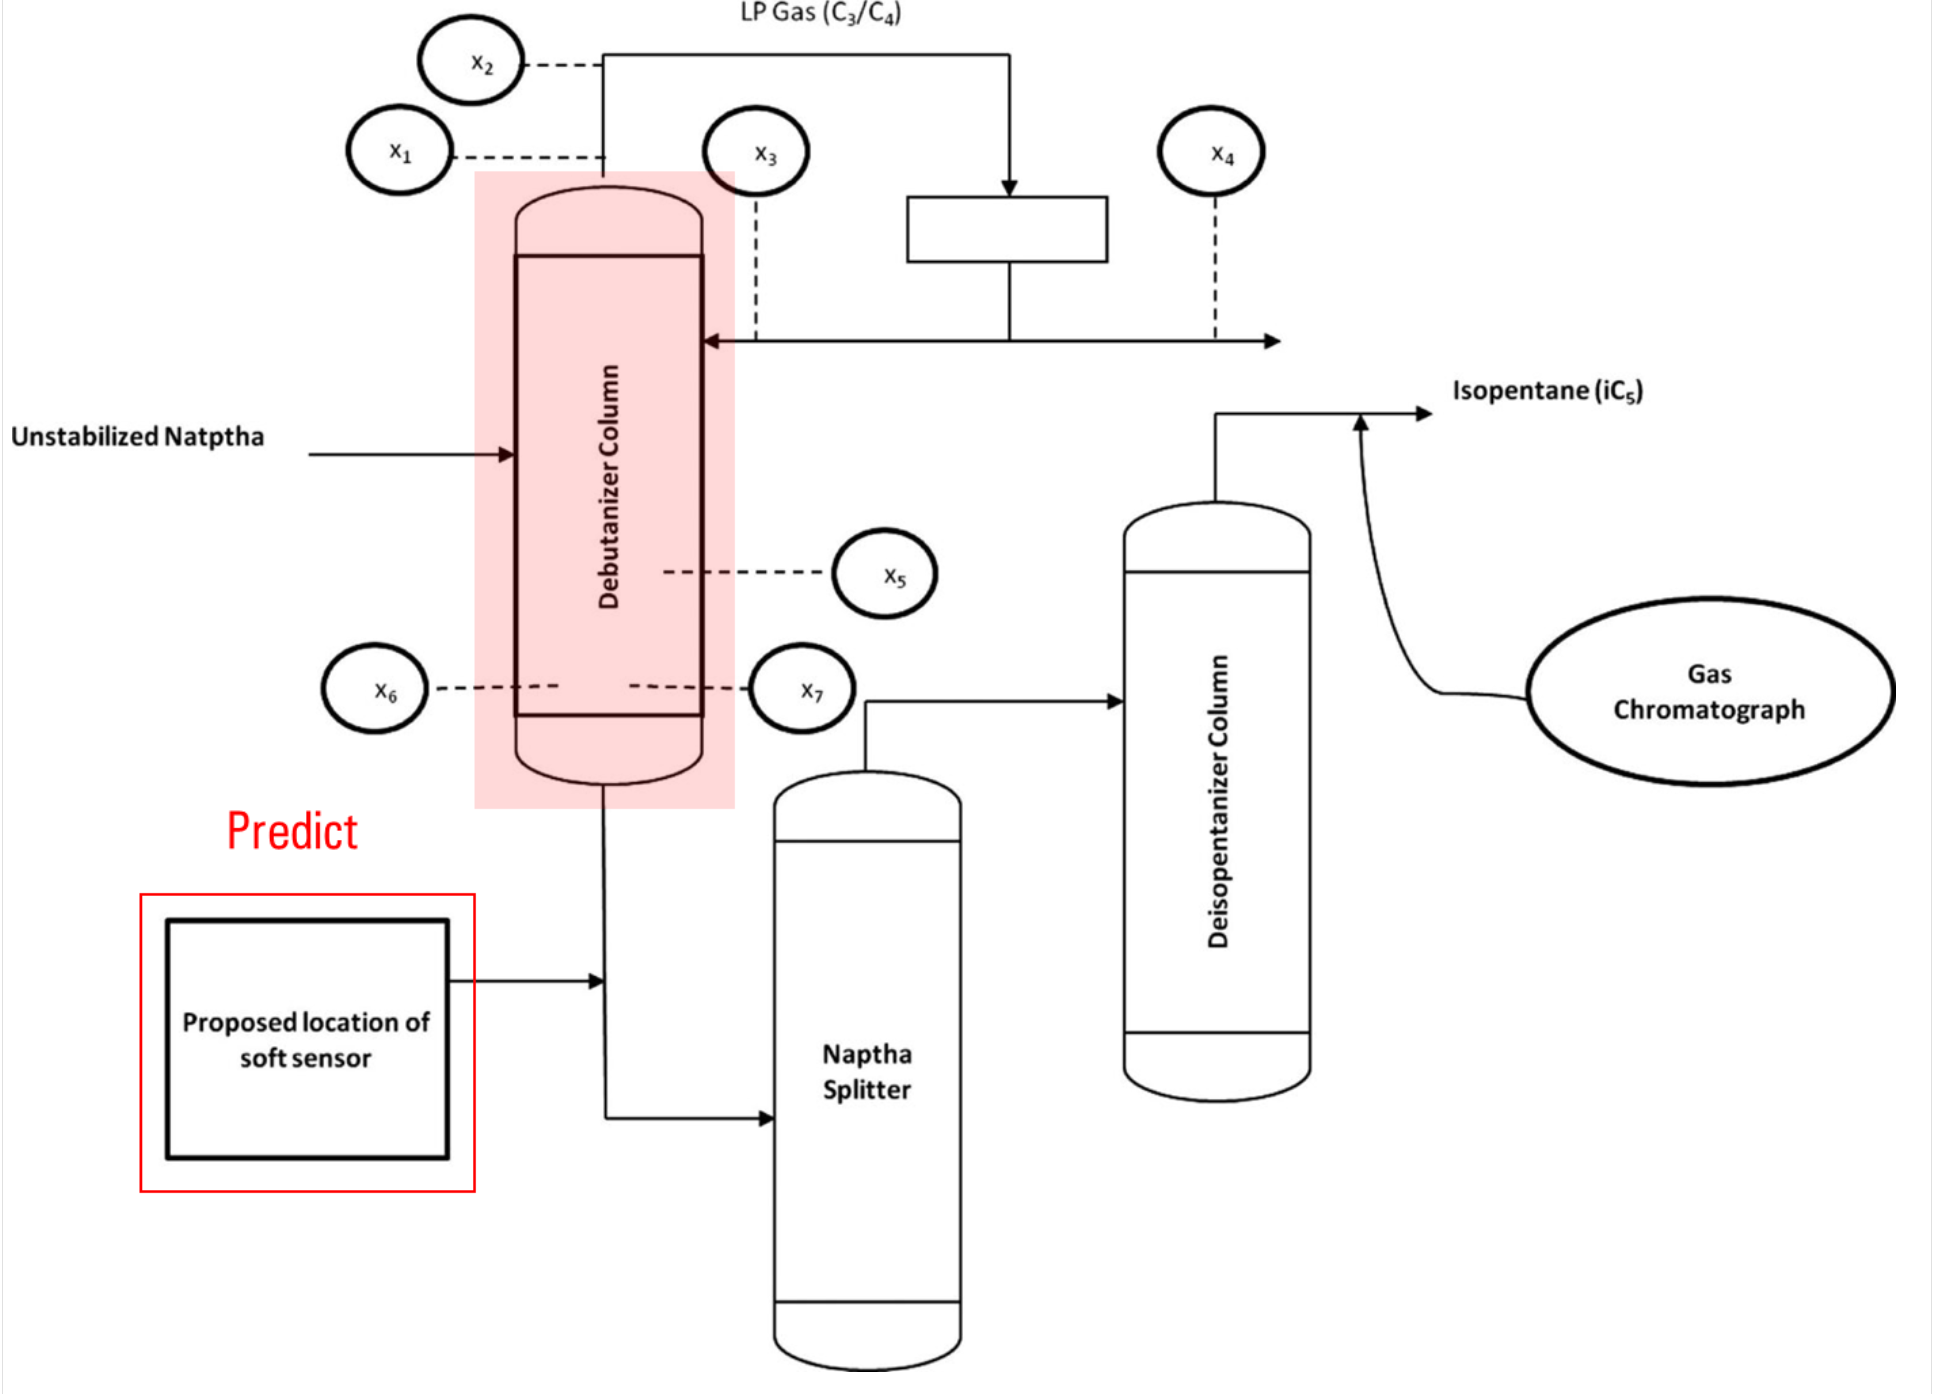

### In this study, we compare the performance of two methods: one that predicts butane concentration y using supervised learning and adds anomaly labels, and another that classifies data into two types using unsupervised learning (One-class SVM and NMF) and adds anomaly labels.  

### The data is divided into training and test data, but since it is time-series data, shuffling is not performed.
### Model evaluation will be performed using the confusion matrix after label prediction on the test data, but since it is important not to miss any anomalies, recall will be given particular emphasis.

## **[Analysis Flow]**

### 1. EDA (Confirm data overall, data size, distribution, cleaning)
### 2. Create Lag features (Convert data)
### 3. Split and Standardize (training 80 / test 20)
### 4. Modeling by training data
### 5. Model evaluation by test data (confusion matrix)
### 6. Parameter optimization (grid search)

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.svm import OneClassSVM
from sklearn.decomposition import NMF
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import (
    confusion_matrix, classification_report,
    roc_curve, precision_recall_curve, auc
)

### Functions used in analysis

In [68]:
# Loading Data
def load_and_clean_data(filepath):
    df = pd.read_csv(filepath)
    df = df.dropna()
    corr_matrix = df.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [col for col in upper.columns if any(upper[col] > 0.95)]
    return df.drop(columns=to_drop)

# TimeSeries Plot
def plot_eda(df):
    columns = [col for col in df.columns if col != 'y']
    plot_columns = columns + ['y']
    
    fig, axes = plt.subplots(3, 3, figsize=(15, 10), sharex=True)
    axes = axes.flatten()
    for i, col in enumerate(plot_columns):
        if i < len(axes):
            axes[i].plot(df.index, df[col])
            axes[i].set_title(f"TimeSeries Plot: {col}")
            axes[i].grid(True)
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')
    plt.tight_layout()
    plt.show()

# BoxPlot
def boxplot(df):
    columns = [col for col in df.columns if col != 'y']
    plot_columns = columns + ['y']
    
    plt.figure(figsize=(10, 5))
    sns.boxplot(data=df[plot_columns])
    plt.title("BoxPlot:data distribution")
    plt.grid(True)
    plt.show()

# HeatMap
def heatmap(df):
    plt.figure(figsize=(10, 8))
    sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap='coolwarm')
    plt.title("HeatMap")
    plt.show()

# Lag Features
def generate_lag_features(df, max_lag=30, corr_threshold=0.65):
    y = df['y']
    X = df.drop(columns='y')
    
    # lag evaluation
    correlations = pd.DataFrame(columns=X.columns)
    for lag in range(max_lag + 1):
        lagged = X.shift(lag)
        corr = lagged.corrwith(y)
        correlations.loc[lag] = corr.abs()
    
    # best lag
    best_lag = correlations.mean(axis=1).idxmax()
    
    # Lag features
    X_lag = X.shift(int(best_lag))
    df_lag = X_lag.copy()
    df_lag['y'] = y
    df_lag.dropna(inplace=True)

    # delete high corr
    corr_matrix = df_lag.drop(columns='y').corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [col for col in upper.columns if any(upper[col] > corr_threshold)]
    df_lag.drop(columns=to_drop, inplace=True)

    # Labeling
    df_lag['label'] = ((df_lag['y'] < 0.1) | (df_lag['y'] > 0.5)).astype(int)
    
    return df_lag, int(best_lag)
    
# Evaluation
def evaluate_model(y_true, scores, threshold_percentile=50):
    threshold = np.percentile(scores, threshold_percentile)
    y_pred = (scores > threshold).astype(int)
    report = classification_report(y_true, y_pred, output_dict=True)
    fpr, tpr, _ = roc_curve(y_true, scores)
    precision, recall, _ = precision_recall_curve(y_true, scores)
    return {
        'report': report,
        'AUC-ROC': auc(fpr, tpr),
        'AUC-PR': auc(recall, precision)
    }

# LinearRegression
def run_linear_regression(X_train, X_test, y_train_cont, y_test):
    model = LinearRegression().fit(X_train, y_train_cont)
    y_pred_cont = model.predict(X_test)
    y_pred_label = ((y_pred_cont < 0.1) | (y_pred_cont > 0.5)).astype(int)
    report = classification_report(y_test, y_pred_label, output_dict=True)
    return {
        'Model': 'Linear Regression',
        'Accuracy': report['accuracy'],
        'Recall': report['1']['recall'],
        'Precision': report['1']['precision'],
        'F1-Score': report['1']['f1-score'],
        'AUC-ROC': None,
        'AUC-PR': None
    }

# One-Class SVM
def run_svm(X_train, X_test, y_test, gamma=0.1, nu=0.01):
    model = OneClassSVM(gamma=gamma,nu=nu).fit(X_train)
    scores = -model.decision_function(X_test)
    result = evaluate_model(y_test, scores)
    return {
        'Model': f'One-Class SVM (γ={gamma}, ν={nu})',
        'Accuracy': result['report']['accuracy'],
        'Recall': result['report']['1']['recall'],
        'Precision': result['report']['1']['precision'],
        'F1-Score': result['report']['1']['f1-score'],
        'AUC-ROC': result['AUC-ROC'],
        'AUC-PR': result['AUC-PR']
    }

# NMF
def run_nmf(X_train, X_test, y_test, n_components=2):
    minmax_scaler = MinMaxScaler()
    X_train_nmf = minmax_scaler.fit_transform(X_train)
    X_test_nmf = minmax_scaler.transform(X_test)
    model = NMF(n_components=n_components, init='random', random_state=42, max_iter=500)
    W = model.fit_transform(X_train_nmf)
    H = model.components_
    X_test_rec = np.dot(np.dot(X_test_nmf, H.T), H)
    errors = ((X_test_nmf - X_test_rec) ** 2).mean(axis=1)
    result = evaluate_model(y_test, errors)
    return {
        'Model': f'NMF (n={n_components})',
        'Accuracy': result['report']['accuracy'],
        'Recall': result['report']['1']['recall'],
        'Precision': result['report']['1']['precision'],
        'F1-Score': result['report']['1']['f1-score'],
        'AUC-ROC': result['AUC-ROC'],
        'AUC-PR': result['AUC-PR']
    }

## 1. EDA

### First, check all data using a time series plot and basic statistics.
### I think the data variation is sufficient, as local fluctuations can be seen in all data. Furthermore, since there is no negative data, NMF can also be applied.

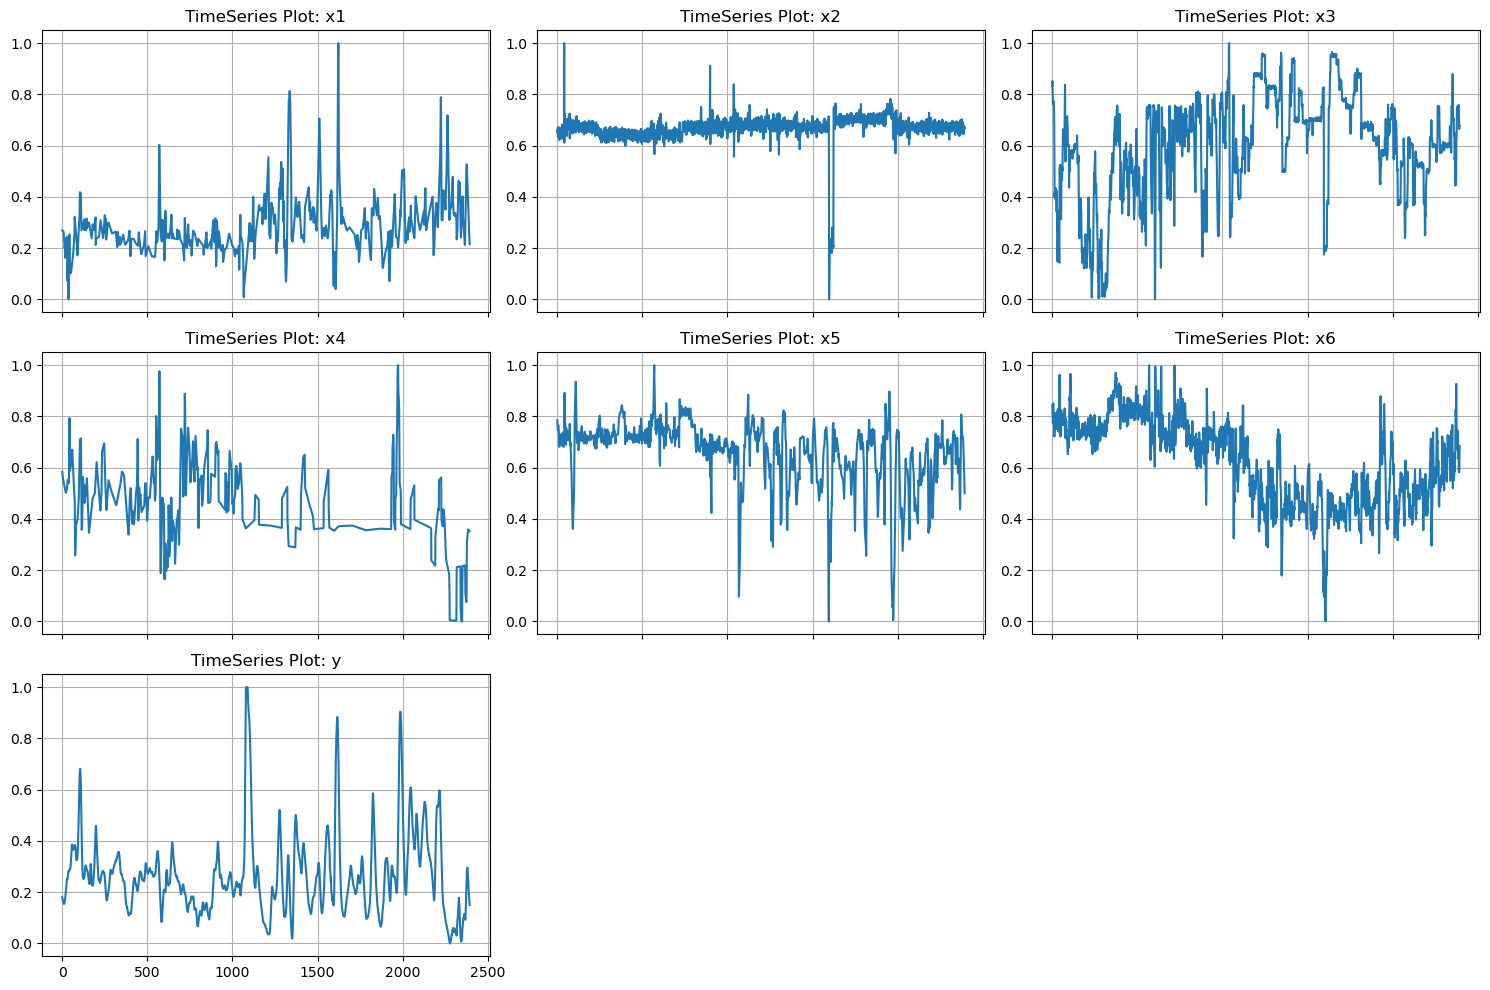

                x1           x2           x3           x4           x5  \
count  2394.000000  2394.000000  2394.000000  2394.000000  2394.000000   
mean      0.283894     0.667847     0.598467     0.435948     0.658086   
std       0.103143     0.057690     0.198581     0.138237     0.127054   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.224004     0.653819     0.500390     0.363369     0.608661   
50%       0.263995     0.671915     0.624269     0.396288     0.694644   
75%       0.325607     0.690943     0.742784     0.518144     0.730119   
max       1.000000     1.000000     1.000000     1.000000     1.000000   

                x6            y  
count  2394.000000  2394.000000  
mean      0.620741     0.267788  
std       0.165116     0.158943  
min       0.000000     0.000000  
25%       0.481804     0.169188  
50%       0.639585     0.246857  
75%       0.755050     0.318061  
max       1.000000     1.000000  


,x1,x2,x3,x4,x5,x6,y
0,0.268900,0.650894,0.832742,0.583420,0.784759,0.843079,0.180295
1,0.268483,0.650140,0.852153,0.577510,0.776487,0.838605,0.177124
2,0.267967,0.659657,0.823618,0.571600,0.764546,0.807879,0.173618
3,0.267451,0.668338,0.808371,0.565689,0.752605,0.799606,0.171640
4,0.266935,0.647191,0.761948,0.559779,0.745326,0.773122,0.166972


In [103]:
# path
filepath = 'debutanizer_data.csv'
# Data Load and visualize
df = load_and_clean_data(filepath)
plot_eda(df)
print(df.describe())
df.head()

### There is no missing value

In [105]:
df.isnull().sum()

x1    0
x2    0
x3    0
x4    0
x5    0
x6    0
y     0
dtype: int64

### Next, from the boxplot below, since the scale of each data are different, standardisation may be necessary for analysis.

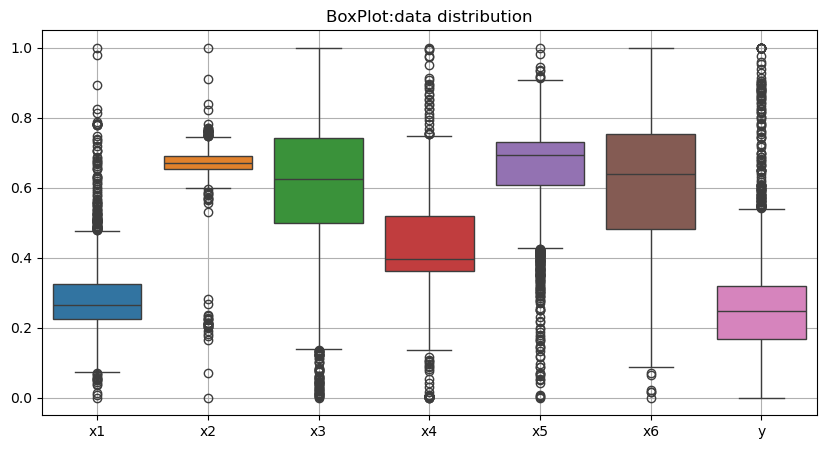

In [71]:
boxplot(df)

### Finally, view the correlation between each feature using a heat map.
### The correlation between y and each sensor data does not appear to be high. Why?

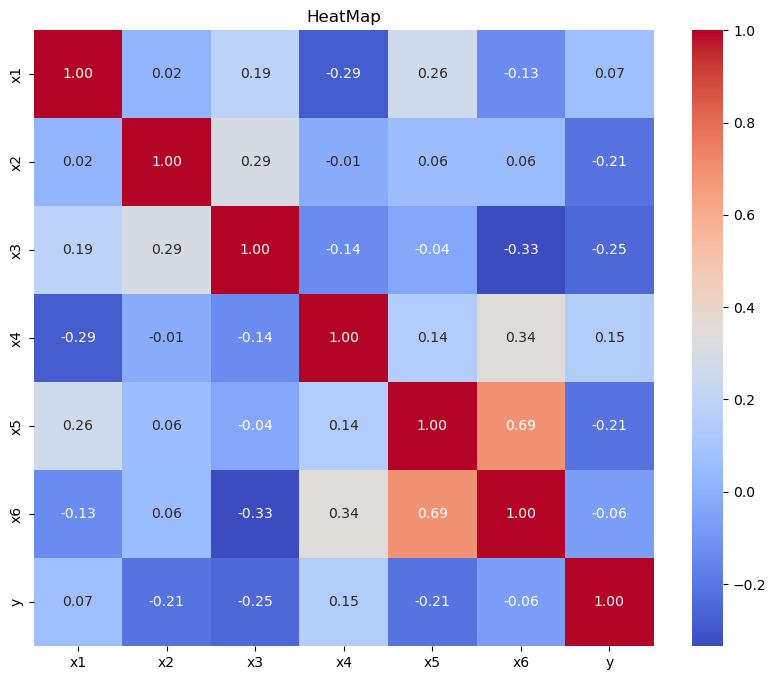

In [72]:
heatmap(df)

## 2. Create Lag features

### It is probably because there is a time lag between when the butane concentration is observed by the sensor data and when the product is discharged.

### Since this delay needs to be corrected, the data set is adjusted to take the delay time into account 
### Creation of lag features：For example, when the lag time Δt = 10, the sensor data at t = 0 is highly correlated with y at t = 10.

### This time, we adopted the highest average correlation coefficient between each data point and y,  Best_lag= 13
### When we check the heat map again, we can see that all correlation coefficients have improved.(and one of the features with high correlation coefficients (x5, x6) was deleted.)

Best Lag Time: 13


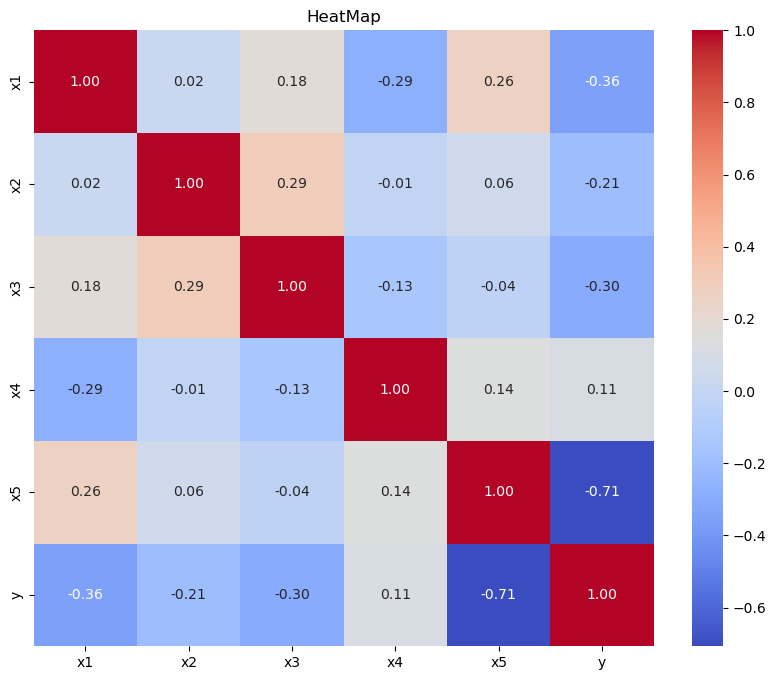

In [73]:
# Lag features
df_lag, best_lag = generate_lag_features(df)
print(f"Best Lag Time: {best_lag}")
heatmap(df_lag.drop(columns='label'))

### One-class SVM may not be able to classify data properly when there is a large amount of abnormal data in the training data. Therefore, we checked the number of normal and abnormal data counts.

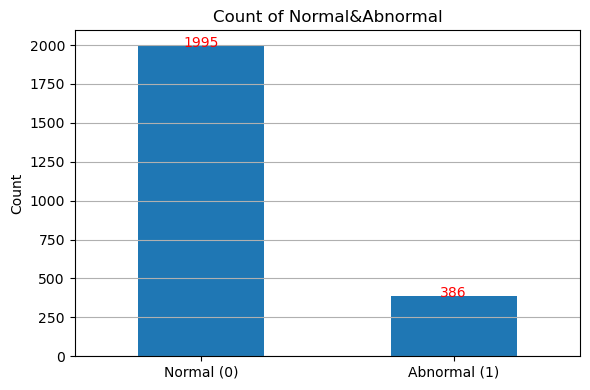

In [74]:
# Count Normal, Abnormal
label_counts = df_lag['label'].value_counts().sort_index()
label_counts.index = ['Normal (0)', 'Abnormal (1)']

# Bar Chart
plt.figure(figsize=(6, 4))
bars = label_counts.plot(kind='bar')
plt.title('Count of Normal&Abnormal')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.grid(axis='y')

# display count
for i, count in enumerate(label_counts):
    plt.text(i, count + max(label_counts)*0.01, str(count), ha='center', va='center', fontsize=10, color='red')

plt.tight_layout()
plt.show()

### Abnormal data counts for less than 20% of the total, so I think it is to be acceptable, Split and standardize data.

## 3. Split and Standardize

In [75]:
# Split data, Standardrize
split_idx = int(len(df_lag) * 0.8)
train_df = df_lag.iloc[:split_idx]
test_df = df_lag.iloc[split_idx:]
X_train = train_df.drop(columns=['y', 'label'])
X_test = test_df.drop(columns=['y', 'label'])
y_train_cont = train_df['y']
y_test = test_df['label']
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [76]:
#Data Shape
train_df.shape, test_df.shape

((1904, 7), (477, 7))

## 4. Modeling by training data
## 5. Model evaluation by test data

In [177]:
# Modeling
results = []
results.append(run_linear_regression(X_train_scaled, X_test_scaled, y_train_cont, y_test))
results.append(run_svm(X_train_scaled, X_test_scaled, y_test, gamma=0.1, nu=0.1))
results.append(run_nmf(X_train, X_test, y_test, n_components=2))

### Linear regression has the lowest recall. It does not classify anomalies well. One-class SVM achieved the best score, correctly classifying more than 70% of anomalies.

In [180]:
# Result
results_df = pd.DataFrame(results)
print("=== Model Evaluation ===")
print(results_df.round(3))

=== Model Evaluation ===
                          Model  Accuracy  Recall  Precision  F1-Score  \
0             Linear Regression     0.673   0.255      0.712     0.376   
1  One-Class SVM (γ=0.1, ν=0.1)     0.690   0.745      0.576     0.649   
2                     NMF (n=2)     0.614   0.647      0.500     0.564   

   AUC-ROC  AUC-PR  
0      NaN     NaN  
1    0.781   0.716  
2    0.684   0.639  


## 6. Parameter optimization (grid search)

### Finally, to further improve the performance of One-Class SVM, we explore the optimal hyperparameters (gannm, nu) by using grid search.

In [174]:
gamma_values = [0.001, 0.01, 0.1, 0.2, 0.3, 0.5]
nu_values = [0.01, 0.05, 0.1, 0.2, 0.3]

# Grid Search
results = []
for gamma in gamma_values:
    for nu in nu_values:
        result = run_svm(X_train_scaled, X_test_scaled, y_test, gamma=gamma, nu=nu)
        results.append(result)

# result best parameter
results_df = pd.DataFrame(results).sort_values(by='F1-Score', ascending=False).reset_index(drop=True)
print(results_df.head())

                           Model  Accuracy    Recall  Precision  F1-Score  \
0  One-Class SVM (γ=0.2, ν=0.01)  0.714885  0.777174   0.600840  0.677725   
1  One-Class SVM (γ=0.1, ν=0.01)  0.710692  0.771739   0.596639  0.672986   
2  One-Class SVM (γ=0.2, ν=0.05)  0.702306  0.760870   0.588235  0.663507   
3  One-Class SVM (γ=0.1, ν=0.05)  0.698113  0.755435   0.584034  0.658768   
4   One-Class SVM (γ=0.2, ν=0.1)  0.698113  0.755435   0.584034  0.658768   

    AUC-ROC    AUC-PR  
0  0.793348  0.718473  
1  0.798894  0.719006  
2  0.784872  0.714362  
3  0.781607  0.711641  
4  0.788600  0.719800  


### From the above, it was not possible to make significant improvements.
### Improvements may be possible by considering other models or performing regression analysis after dimension reduction using unsupervised learning.